#Mounting & Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation,RandomFlip,Rescaling
from tensorflow.keras.callbacks import EarlyStopping
import shutil
from tensorflow.keras.models import load_model, Model, Sequential
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from matplotlib import pyplot as plt
from tensorflow.keras import applications

In [ ]:
!pip install -q --upgrade wandb
import wandb
from wandb.keras import WandbCallback
wandb.login()

wandb: Currently logged in as: eberrino (use `wandb login --relogin` to force relogin)


True

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./03. Utils')
import importlib
import MyFunctions
importlib.reload(MyFunctions)

<module 'MyFunctions' from '/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./03. Utils/MyFunctions.py'>

#The Model

https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33
https://github.com/priya-dwivedi/Deep-Learning/tree/master/resnet_keras

In [ ]:
IMAGE_SIZE = (128,128)
NUM_CLASSES = 3 
BATCH_SIZE = 32 

In [ ]:
df_train=pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/train0-7.xlsx")
df_test=pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/test0-7.xlsx")

In [ ]:
train_datagen = ImageDataGenerator(validation_split = 0.2,rescale = 1./255,horizontal_flip=True,rotation_range=40)
dir = '/content/drive/My Drive/Quinto_Anio/TESIS_Eugenia_Berrino/DS_comp_nodef'
train_batches = train_datagen.flow_from_dataframe( 
    df_train, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset = "training",
    seed=42,
    class_mode="categorical",)

Found 13951 validated image filenames belonging to 3 classes.


In [ ]:
valid_batches = train_datagen.flow_from_dataframe(df_train, directory=dir,
                                            x_col='ImageID',y_col='Projection',
                                            target_size=IMAGE_SIZE,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            subset = "validation",
                                            seed=42,
                                            class_mode="categorical",)

Found 3487 validated image filenames belonging to 3 classes.


In [ ]:
base_model = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (IMAGE_SIZE[0], IMAGE_SIZE[1], 3) )
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(NUM_CLASSES , activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
from keras.optimizers import SGD, Adam
adam = Adam(learning_rate=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
run = wandb.init(project='filter',
                 config={ 
                     "learning_rate": 0.0001,
                     "epochs": 30,
                     "batch_size": 32,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "resnet50",
                     "dataset": "PA - Filtering"
                 })
config = wandb.config

In [ ]:
history = model.fit(train_batches, validation_data = valid_batches , epochs = 30,workers=8, 
                    callbacks=[EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True),WandbCallback()], batch_size = BATCH_SIZE)

Epoch 1/30
436/436 [==============================] - 195s 361ms/step - loss: 0.1210 - accuracy: 0.9708 - val_loss: 2.0859 - val_accuracy: 0.0510


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
436/436 [==============================] - 159s 360ms/step - loss: 0.0457 - accuracy: 0.9910 - val_loss: 1.3510 - val_accuracy: 0.4408
Epoch 3/30
436/436 [==============================] - 157s 357ms/step - loss: 0.0413 - accuracy: 0.9912 - val_loss: 0.0455 - val_accuracy: 0.9920
Epoch 4/30
436/436 [==============================] - 158s 358ms/step - loss: 0.0381 - accuracy: 0.9918 - val_loss: 0.0402 - val_accuracy: 0.9934
Epoch 5/30
436/436 [==============================] - 157s 356ms/step - loss: 0.0377 - accuracy: 0.9923 - val_loss: 0.0674 - val_accuracy: 0.9822
Epoch 6/30
436/436 [==============================] - 159s 356ms/step - loss: 0.0382 - accuracy: 0.9923 - val_loss: 0.0333 - val_accuracy: 0.9937
Epoch 7/30
436/436 [==============================] - 156s 353ms/step - loss: 0.0334 - accuracy: 0.9931 - val_loss: 0.0451 - val_accuracy: 0.9908
Epoch 8/30
436/436 [==============================] - 156s 350ms/step - loss: 0.0337 - accuracy: 0.9920 - val_loss: 0.1006 -

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Filtro_Bietapico_Segundo.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


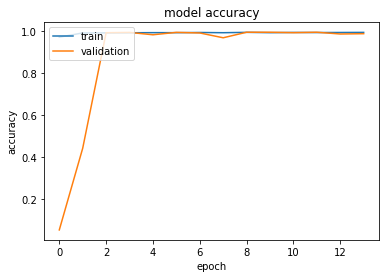

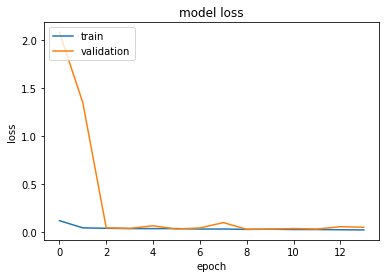

In [ ]:
MyFunctions.plot_history(history)

# Test

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_batches = test_datagen.flow_from_dataframe(
    df_test, 
    directory=dir,
    x_col='ImageID',y_col='Projection',
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=1,
    seed=42,
    class_mode="categorical"#, validate_filenames=False
    )

Found 4360 validated image filenames belonging to 3 classes.


In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./04. Weights/Filtro_Bietapico_Segundo.h5')

In [ ]:
#Calculamos la matriz de predicciones
result_test=model.predict(test_batches, verbose=1)
print(result_test.shape)
pd.DataFrame(result_test).to_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Results/result_test_Bietapico_II.csv')

4360/4360 [==============================] - 1336s 306ms/step
(4360, 3)


In [ ]:
#Obtenemos el nombre de clase asociado a cada indice
classes_dict = dict(zip(train_batches.class_indices.values(),train_batches.class_indices.keys()))
classes_dict

{0: 'AP_horizontal', 1: 'L', 2: 'PA'}

In [ ]:
preds_classes, gts = MyFunctions.after_test(classes_dict,result_test,test_batches)

PA               2725
L                1436
AP_horizontal     199
dtype: int64
               precision    recall  f1-score   support

AP_horizontal       0.98      0.90      0.94       217
            L       0.99      1.00      1.00      1427
           PA       0.99      1.00      0.99      2716

     accuracy                           0.99      4360
    macro avg       0.99      0.97      0.98      4360
 weighted avg       0.99      0.99      0.99      4360



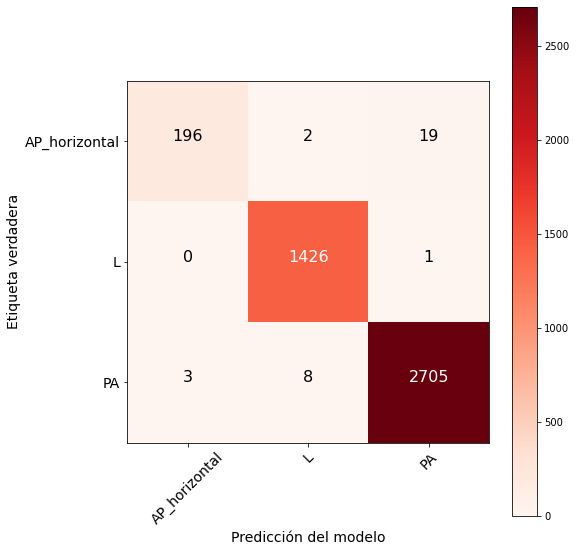

In [ ]:
MyFunctions.plot_confusion_matrix(gts,preds_classes,test_batches.class_indices.keys(),
                                  path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Images/CM_Filtro_Bi_II')

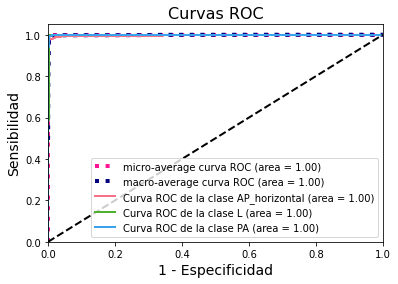

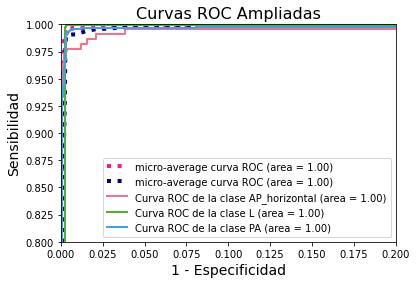

In [ ]:
MyFunctions.plot_ROC(result_test,gts,NUM_CLASSES, classes_dict,
                     path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Images/ROC_Filtro_Bi_II')

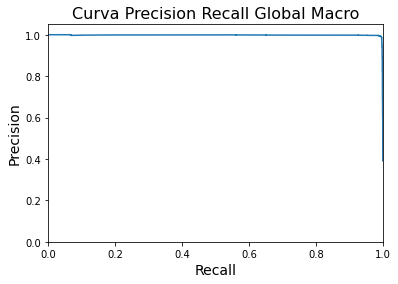

In [ ]:
MyFunctions.precision_recall_global(result_test,gts,NUM_CLASSES,
                     path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Images/PRG_Filtro_Bi_II')

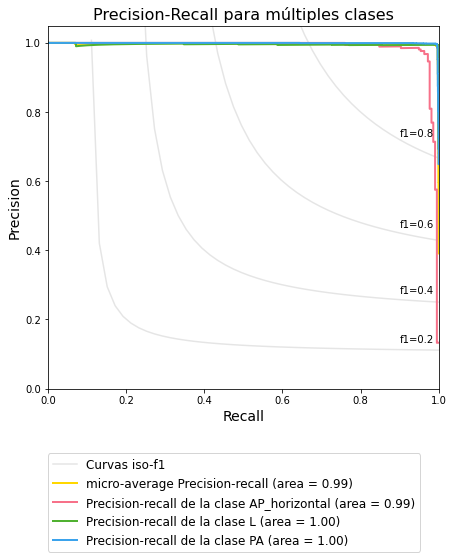

In [ ]:
MyFunctions.precision_recall_many(result_test,gts,NUM_CLASSES, classes_dict,
                                  path='/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Images/PRM_Bi_II')

# Guardado Resultados Finales

In [ ]:
df_test = pd.read_excel("/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/test0-7.xlsx")
df_res  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Results/result_test_Bietapico_II.csv')

In [ ]:
df_res = df_res.drop(columns='Unnamed: 0')
df_res.columns

Index(['0', '1', '2'], dtype='object')

In [ ]:
classes_dict = {0:'AP_horizontal',1:'L',2:'PA'}
preds_classes = MyFunctions.after_test(classes_dict,df_res.to_numpy(),both=0)

PA               2725
L                1436
AP_horizontal     199
dtype: int64


In [ ]:
df_test["Pred"] = preds_classes

In [ ]:
df_test

,Unnamed: 0,ImageID,ImageDir,Projection,Pred
0,0,5/117461681536540587607592076584888612953_wmoy...,5,PA,PA
1,1,0/214260817085057432303623958907855926368_jrl2...,0,PA,PA
2,2,4/144306045728819370188471558682816175107_vhmd...,4,PA,PA
3,3,1/213096160366986458367121958911602047465_wble...,1,PA,PA
4,4,4/280022667207150747197673782766436308679_15wi...,4,PA,PA
...,...,...,...,...,...
4355,4355,1/201028909759225999897549410032918111027_-ruc...,1,PA,PA
4356,4356,6/155634289149161267049279102303067537749_ba86...,6,L,L
4357,4357,2/282333874080047874618440451478871639364_1xiw...,2,PA,PA
4358,4358,5/99711541869715028575308087414656016123_cysyz...,5,L,L


In [ ]:
df_test["result"] = df_test["Projection"]==df_test["Pred"]
df_test.head()

,Unnamed: 0,ImageID,ImageDir,Projection,Pred,result
0,0,5/117461681536540587607592076584888612953_wmoy...,5,PA,PA,True
1,1,0/214260817085057432303623958907855926368_jrl2...,0,PA,PA,True
2,2,4/144306045728819370188471558682816175107_vhmd...,4,PA,PA,True
3,3,1/213096160366986458367121958911602047465_wble...,1,PA,PA,True
4,4,4/280022667207150747197673782766436308679_15wi...,4,PA,PA,True


In [ ]:
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Resultados/Resultado_final_segunda_etapa.csv')

#Análisis de predicciones incorrectas
Además de mostrarse cada una de las imágenes con el resultado de su predicción y su GT, se guardan en la carpeta correspondiente en el save_path, separadas en imágenes bien clasificadas y mal clasificadas (argumento bad=True/False) 

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Resultados/Resultado_final_segunda_etapa.csv')

In [ ]:
df_test_bad=df_test[df_test["result"]==False]
df_test_bad.head()

,ImageID,ImageDir,Projection,Pred,result
76,4/51660009030804800622517791419411123073_-6v4c...,4,PA,L,False
94,5/26058313305469716031660539225317181435_luhas...,5,PA,L,False
532,0/125208930338141968501244764499259500218_arhz...,0,PA,AP_horizontal,False
559,3/322729003998044809439852710028606111975_arku...,3,L,PA,False
1012,3/56701595333745016141492542602184170433_4t0df...,3,AP_horizontal,PA,False


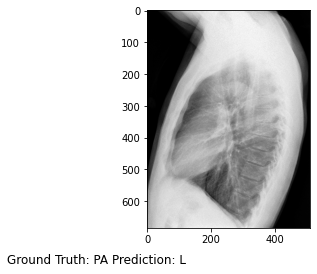

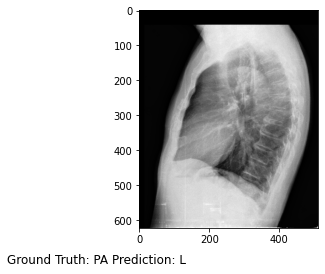

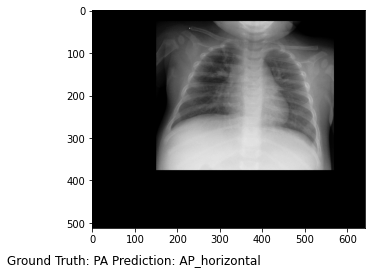

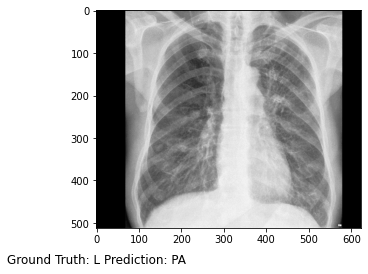

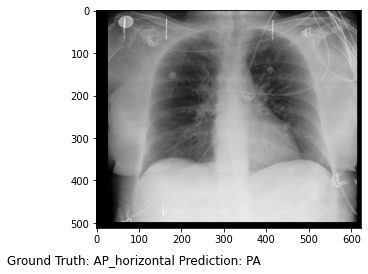

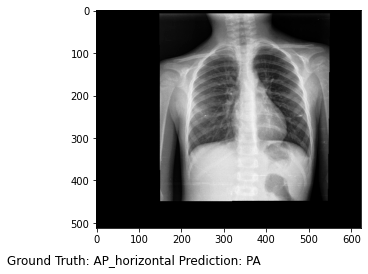

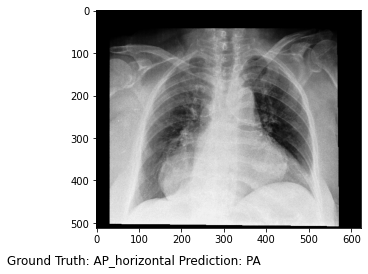

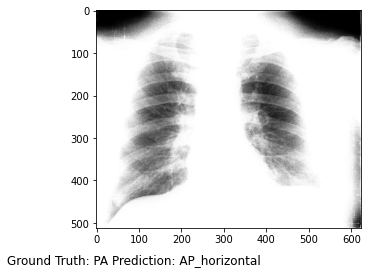

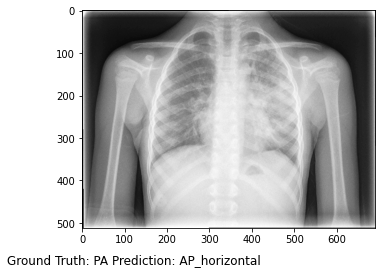

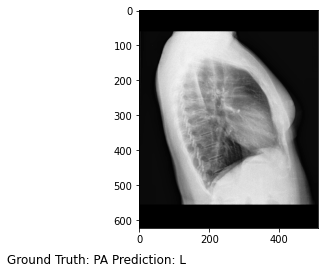

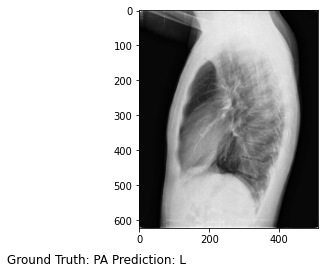

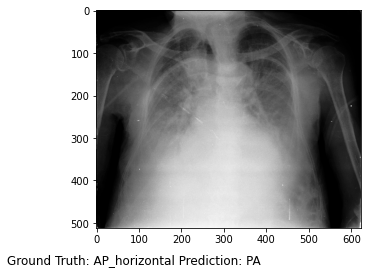

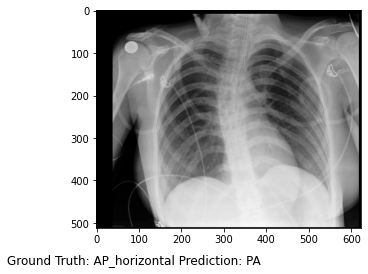

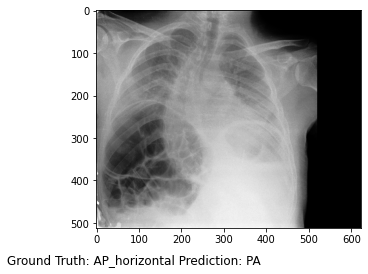

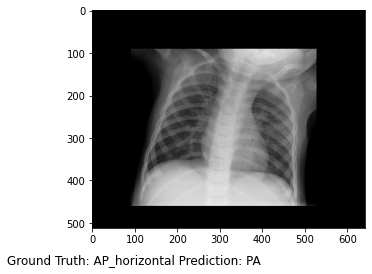

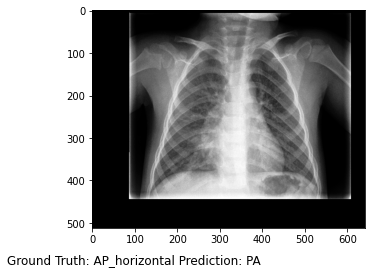

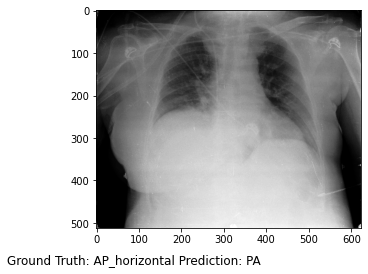

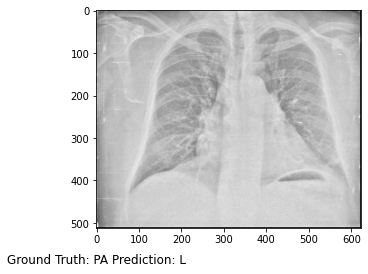

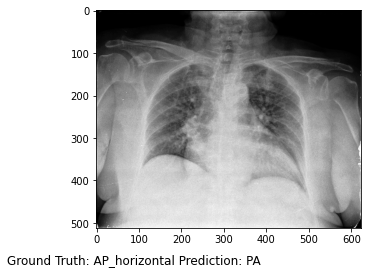

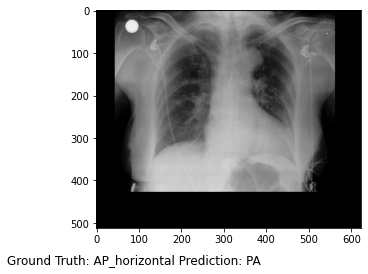

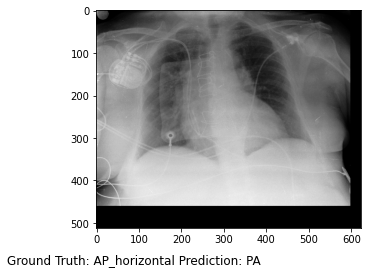

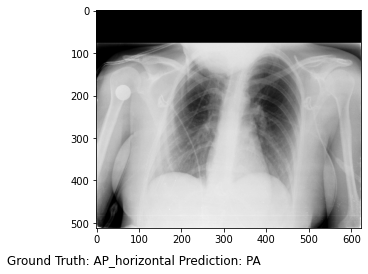

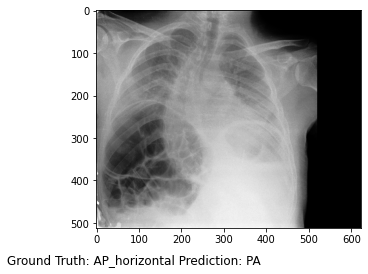

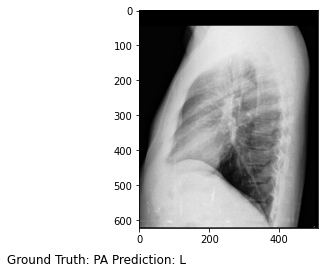

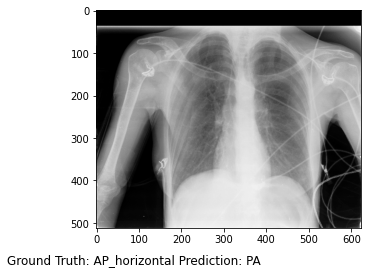

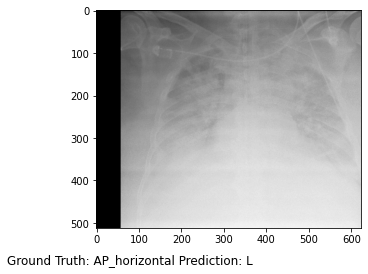

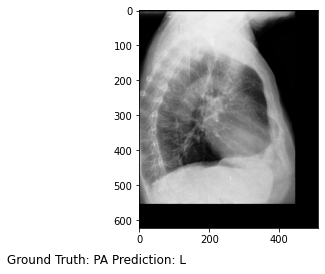

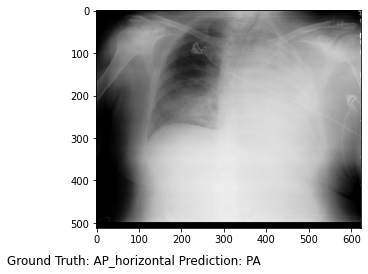

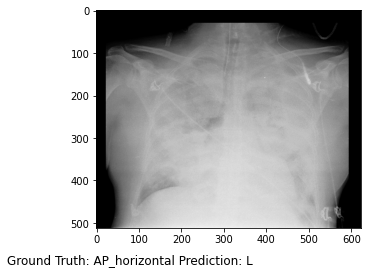

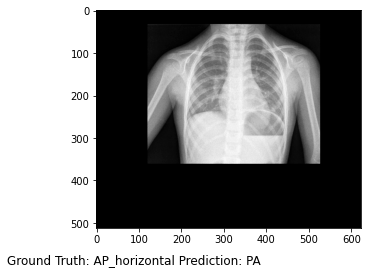

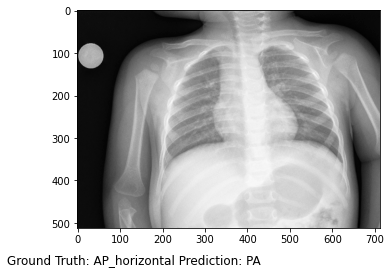

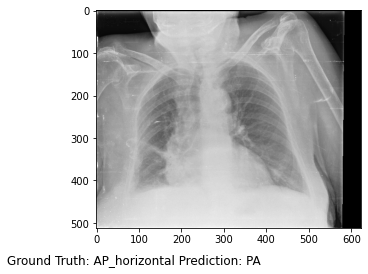

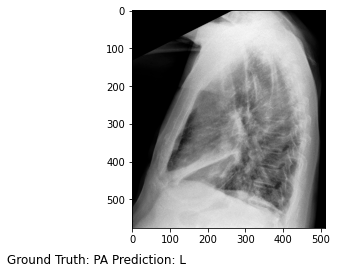

In [ ]:
image_path = '/content/drive/MyDrive/Quinto_Anio/TESIS_Eugenia_Berrino/DS_comp_nodef/'
save_path  = '/content/drive/MyDrive/Colab Notebooks/PFC - Berrino E./01. Filtrado/02. Exp 1: Cantidad de etapas de Filtrado/Resultados/Imágenes/Segunda_Etapa'
MyFunctions.save_image_results(df_test_bad,image_path,save_path,plot=True)

# Análisis de Predicciones Correctas
Como la mayor parte de las imágenes fueron correctamente clasificadas, se trabaja con una muestra. 

In [ ]:
df_test_good = df_test[df_test["result"]==True]
df_test_good.head()

,ImageID,ImageDir,Projection,Pred,result
0,5/117461681536540587607592076584888612953_wmoy...,5,PA,PA,True
1,0/214260817085057432303623958907855926368_jrl2...,0,PA,PA,True
2,4/144306045728819370188471558682816175107_vhmd...,4,PA,PA,True
3,1/213096160366986458367121958911602047465_wble...,1,PA,PA,True
4,4/280022667207150747197673782766436308679_15wi...,4,PA,PA,True


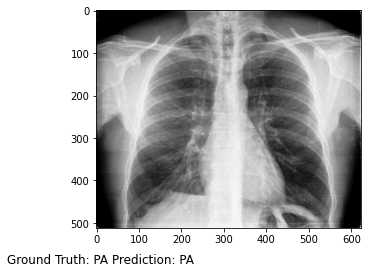

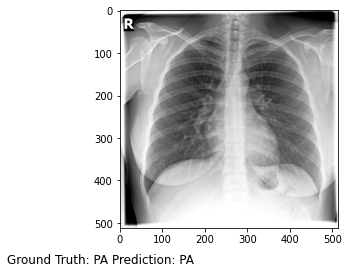

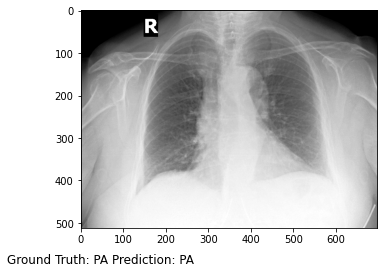

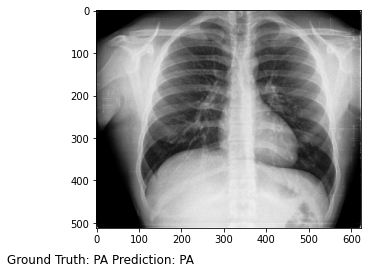

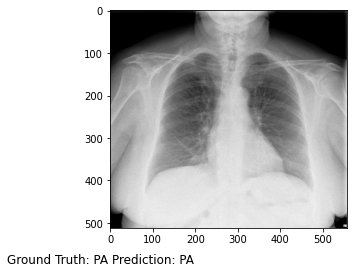

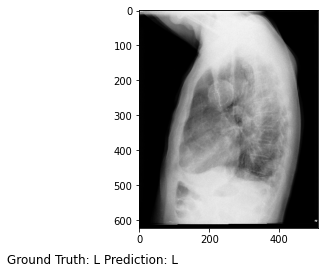

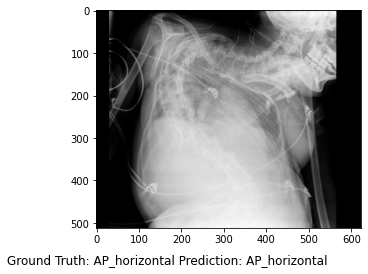

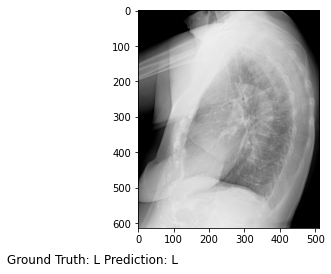

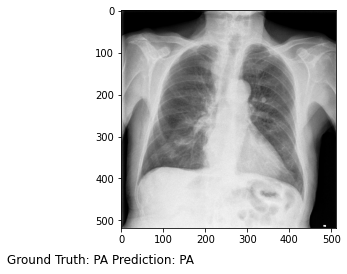

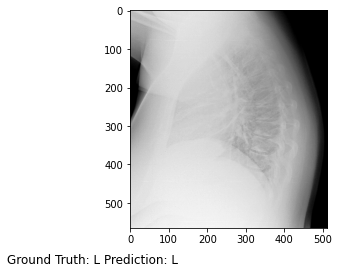

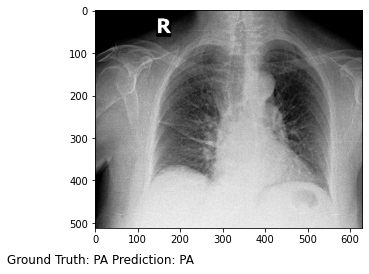

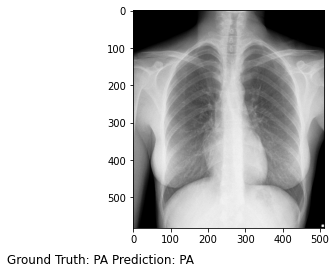

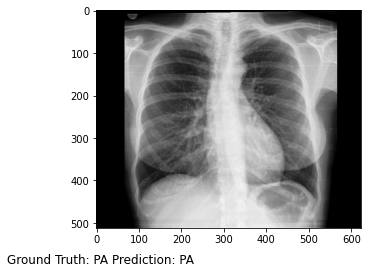

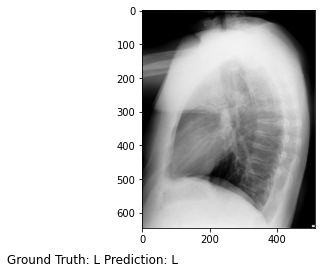

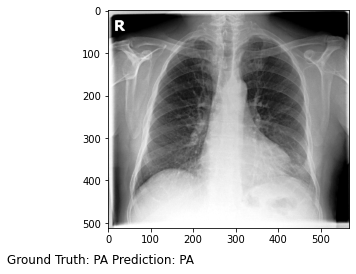

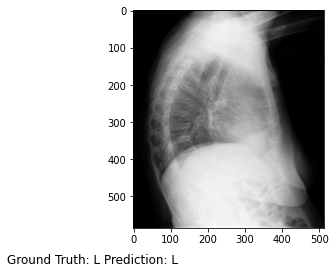

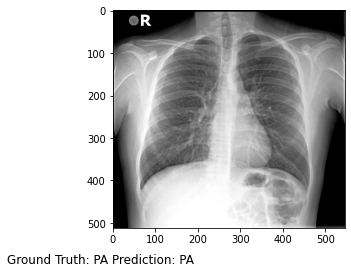

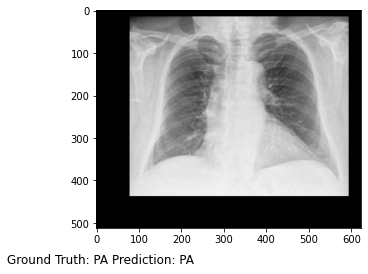

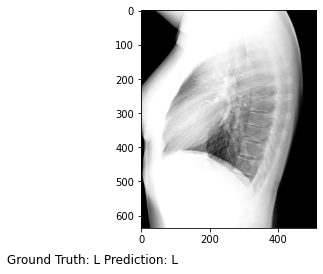

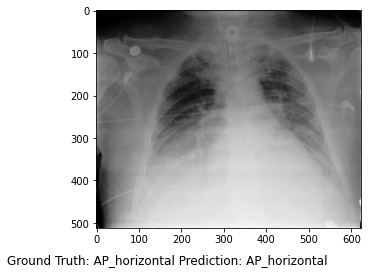

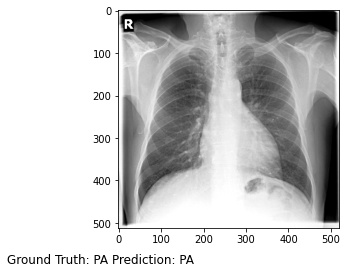

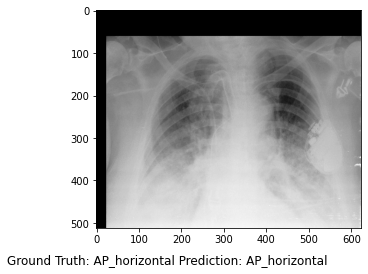

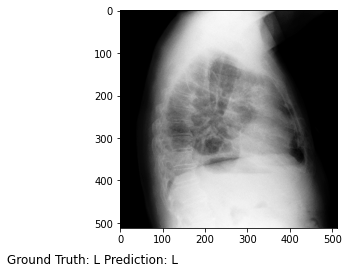

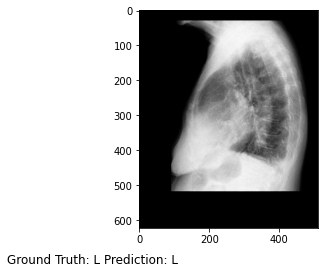

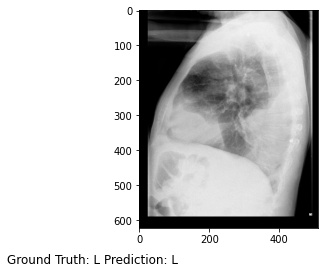

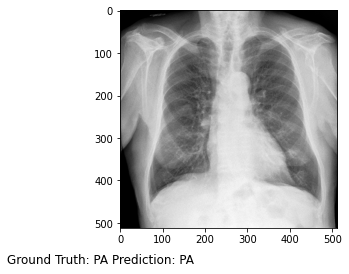

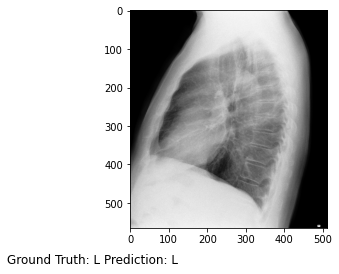

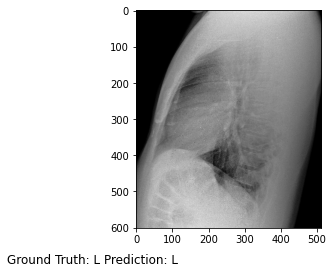

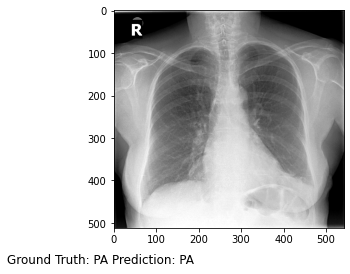

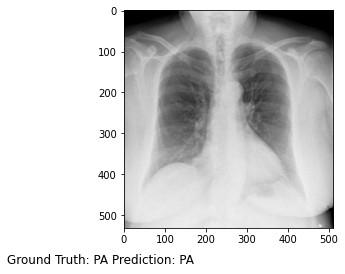

In [ ]:
MyFunctions.save_image_results(df_test_good[0:30],image_path,save_path,bad = False,plot=True)